In [2]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score  
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
from datetime import datetime

### Data set read in, cleaning, munging and EDA

## Inpatient prospective payment system provider summary for the top diagnosis-related groups


In [3]:
A_new = pd.read_csv('../datasets/hospi-group.csv', sep = ',')

In [4]:
rename3_map = {
    # Original column: [renamed column]
    'Provider Id':    'Provider_ID', 
      }
A_new.rename(columns=rename3_map, inplace=True)


In [5]:
A_new.head(2)  # Renamed Provider ID

,DRG Definition,Provider_ID,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71


In [138]:
def cleaning(df, column10, column11, column12):
    

    # This renamesome of the columns in the DataFrame
    df=df.rename(columns={' Total Discharges ':'TotalDischrg',
                          ' Average Covered Charges ':'AvgCovCharg',
                         ' Average Total Payments ':'AvgTotalPay',
                         'Average Medicare Payments':'AvgMedicarePay'})
    
    # This replaces the string '$' and convert the dtype to float
    df[column10] = [i.replace('$', "") for i in df[column10]]
    df[column10] = df[column10].astype(float)
    df[column11] = [i.replace('$', "") for i in df[column11]]
    df[column11] = df[column11].astype(float)
    df[column12] = [i.replace('$', "") for i in df[column12]]
    df[column12] = df[column12].astype(float)
    
    
    
    
    return df

In [139]:
# calling the function to deliminate string and conver to flaot
st2 = cleaning(A_new,'AvgTotalPay','AvgCovCharg','AvgMedicarePay' )  

Text(0,0.5,'Provider_ID')

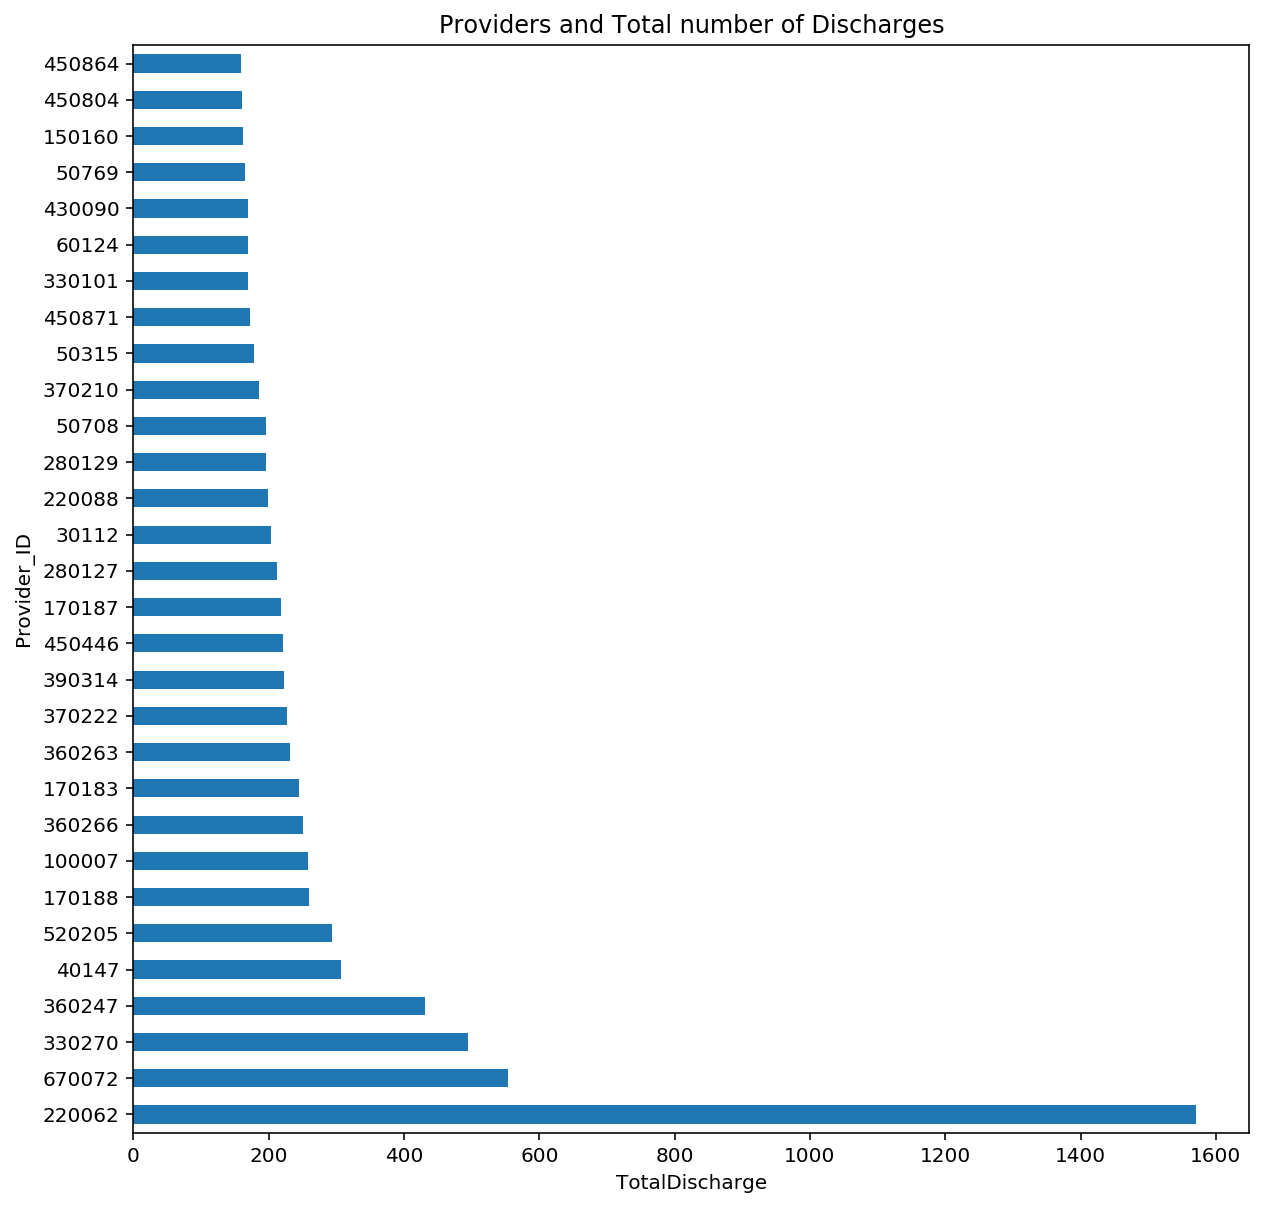

In [145]:
# Graph showing Total number of Discharges per DRG Definition
fig, ax = plt.subplots(figsize = (10, 10))
st2.groupby('Provider_ID')['TotalDischrg'].mean().sort_values(
    ascending=False).head(30).plot('barH', 
                                                            ax = ax, title = 'Providers and Total number of Discharges')
plt.xlabel('TotalDischarge')
plt.ylabel('Provider_ID')

In [146]:
# just to confirm the result of the graph
st = st2.groupby(['Provider_ID'])['TotalDischrg'].mean().reset_index().sort_values(by='TotalDischrg', ascending=False)

In [147]:
st.head()

,Provider_ID,TotalDischrg
1444,220062,1571.00
3332,670072,553.00
2058,330270,494.50
2294,360247,431.00
206,40147,306.75


### Now i needed to find out how much on average medicare pays for respective DRG definition so to know why the provider with the most number of discharge got less medicare pay

In [148]:
# taking a count of DRG Definition and medicare average so as to find out which DRG Definition medicare pays the most 
dr_count = pd.DataFrame(st2.groupby(['Provider_ID','Provider Name']).agg({'DRG Definition':'count','TotalDischrg':'mean',
                                                            'AvgMedicarePay':'mean'})).reset_index()

In [149]:
dr_count['DRG Definition'] = st2['DRG Definition']

### Here are the top three DRG Definition that cost the most per medicare pay.
below is the graph showing top DRG Definitions by measure of their respective Medicare pay 

#### This result show that not really the number of discharges but the DRG Definition dictates medicare rate. having exhaustively confirmed this we would look into other factors that might be determinant

In [150]:
dr_count.sort_values(by='AvgMedicarePay',ascending=False).head(3)

,Provider_ID,Provider Name,DRG Definition,TotalDischrg,AvgMedicarePay
3143,490142,UVA HEALTH SCIENCES CENTER,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,18.000000,41836.880000
540,60096,VAIL VALLEY MEDICAL CENTER,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,48.000000,39943.165000
1102,150166,PINNACLE HOSPITAL,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,17.571429,25098.252857


In [152]:
dr_counttop =dr_count.sort_values(by='AvgMedicarePay', ascending=False).head(50)

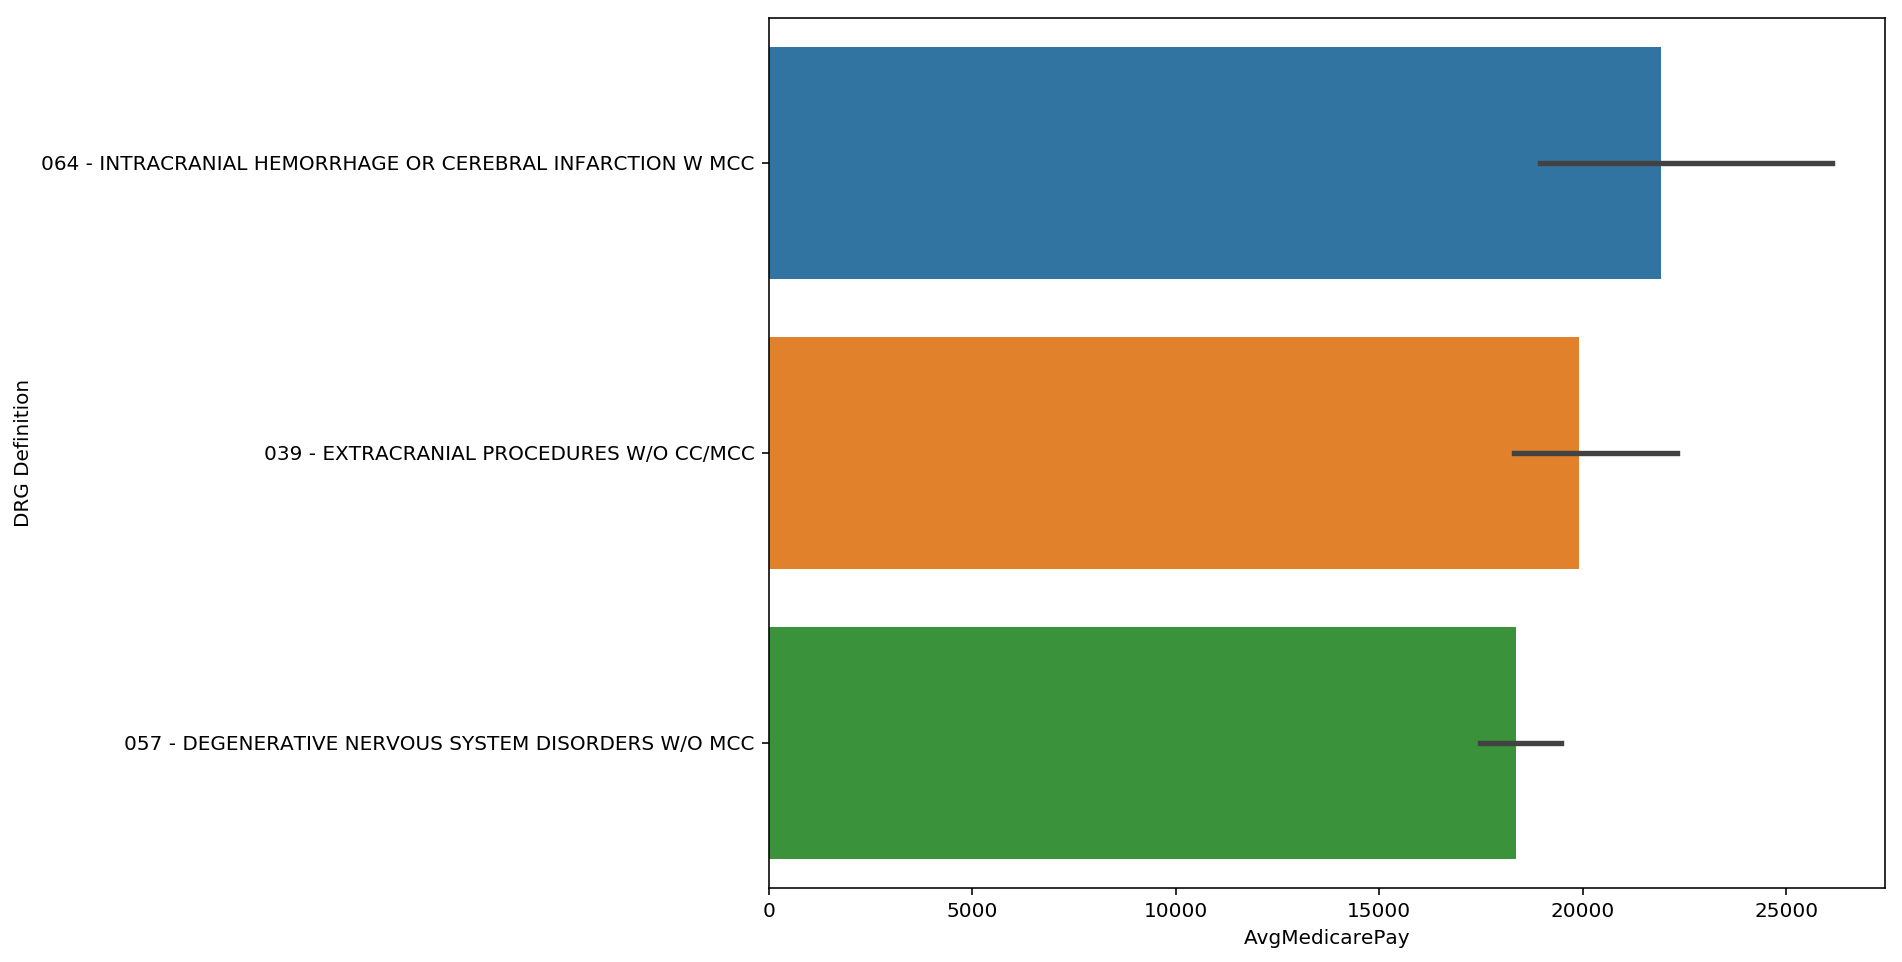

In [153]:
# Graph showing top DRG Definition by measure of their Medicare pay
fig, ax = plt.subplots(figsize=(10,8))  
sns.barplot(x='AvgMedicarePay', y='DRG Definition', data=dr_counttop,  ax=ax)

### The graph below shows providers and their respective medicare pay rate

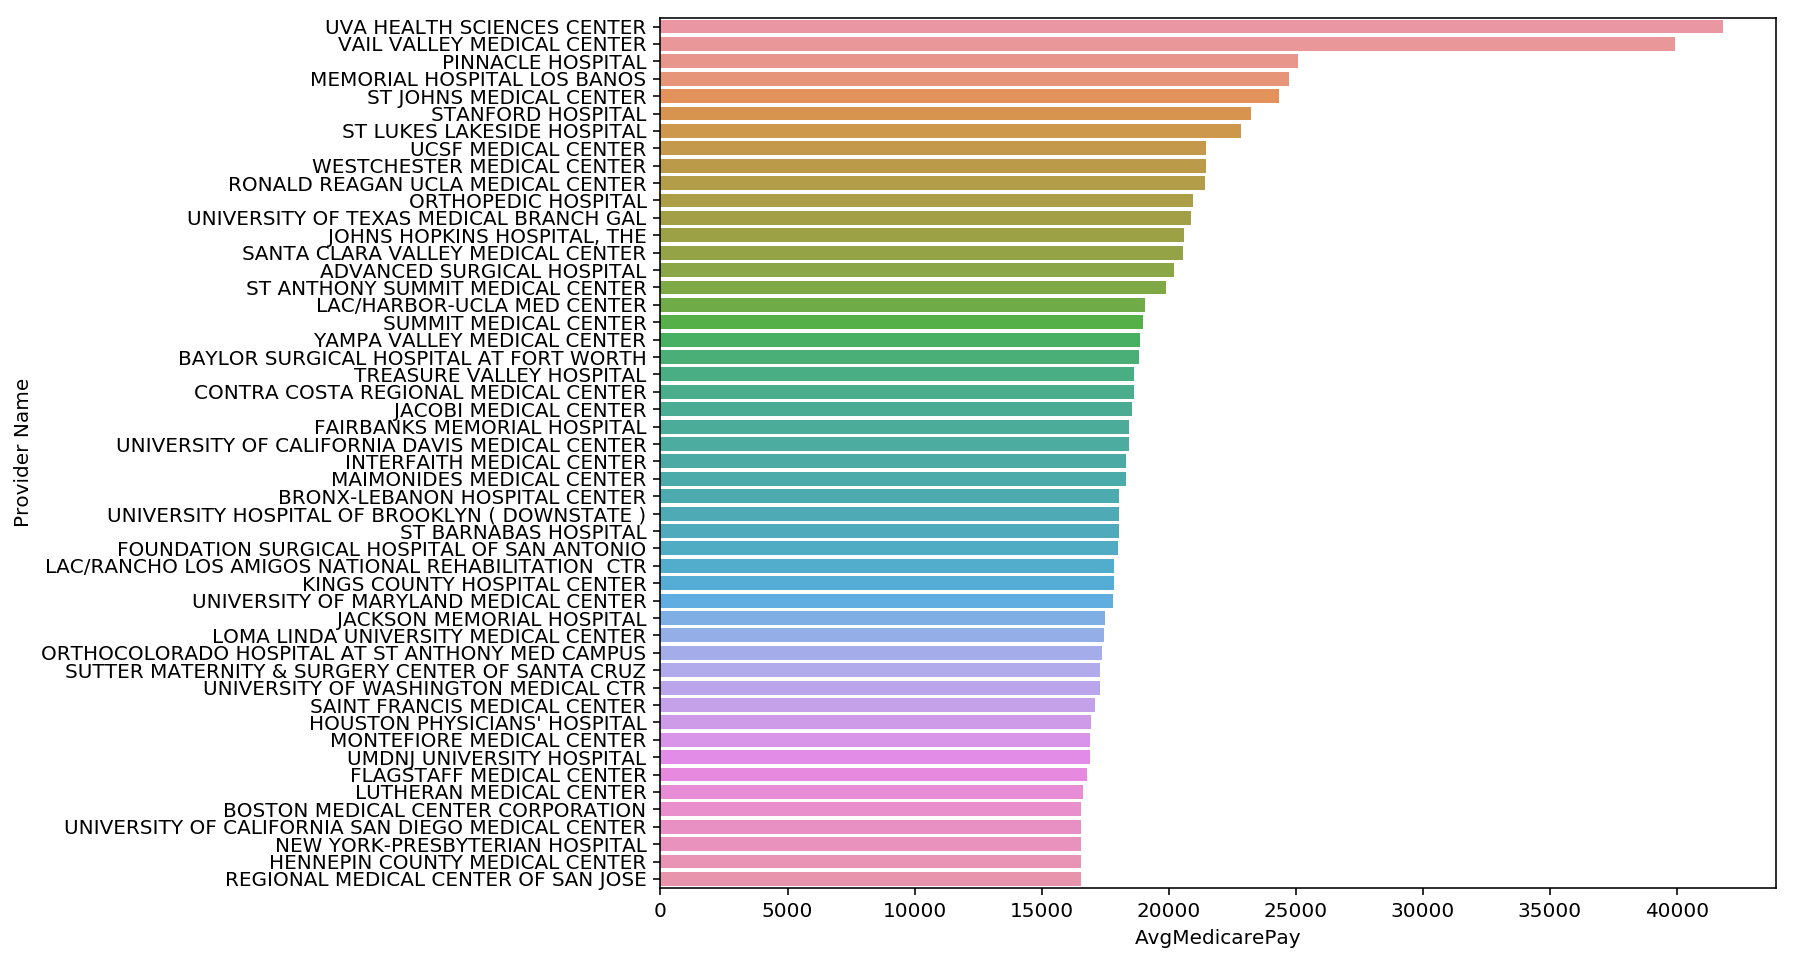

In [154]:
# Providers their respective Medicare pay on average
fig, ax = plt.subplots(figsize=(10,8))  
sns.barplot(x='AvgMedicarePay', y='Provider Name', data=dr_counttop,  ax=ax)

Text(0,0.5,'DRG Definition')

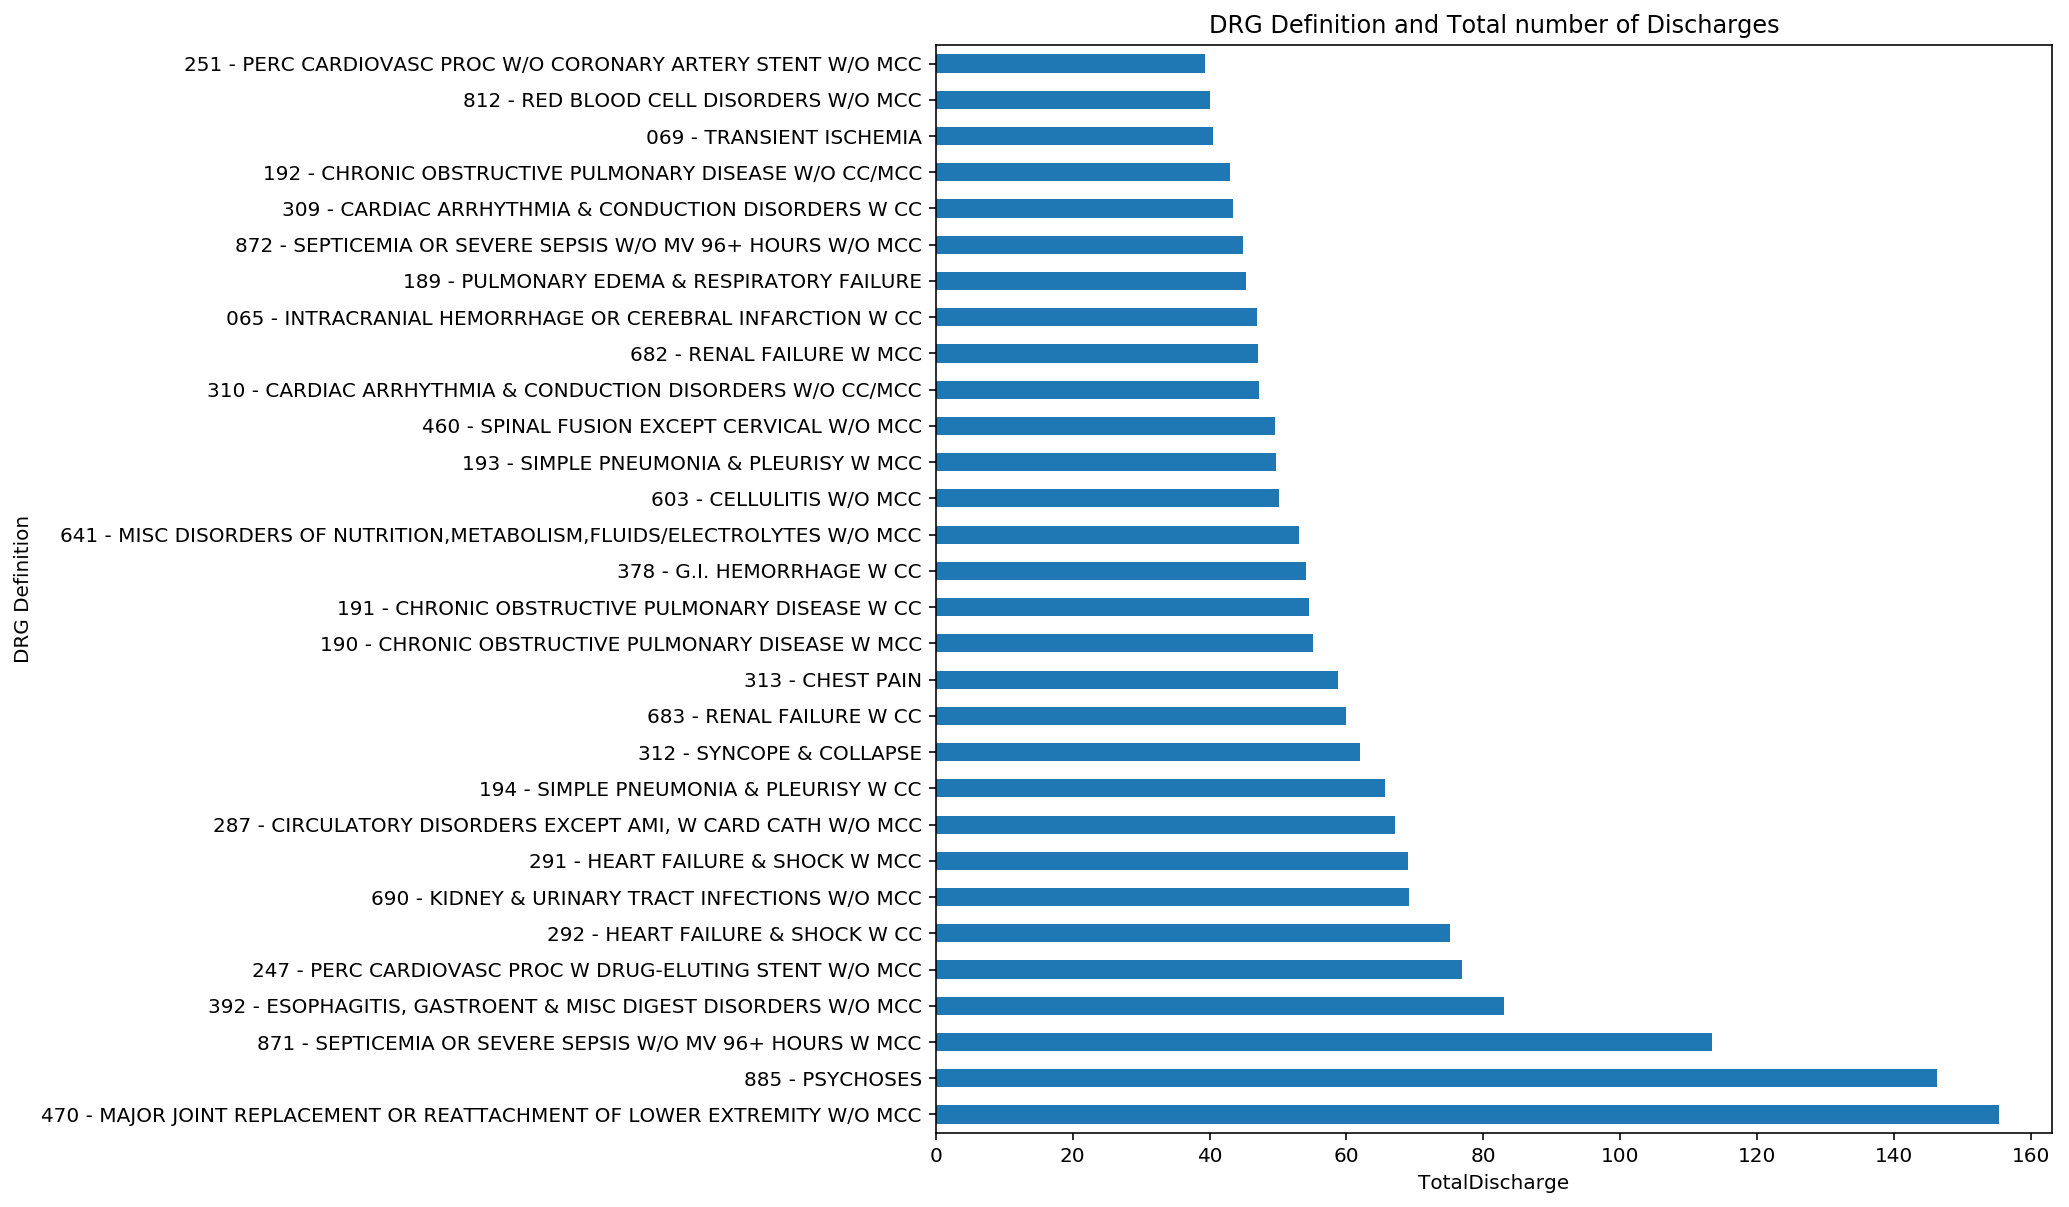

In [155]:
# Graph showing Total number of Discharges per DRG Definition
fig, ax = plt.subplots(figsize = (10, 10))
st2.groupby('DRG Definition')['TotalDischrg'].mean().sort_values(
    ascending=False).head(30).plot('barH', 
                                                            ax = ax, title = 'DRG Definition and Total number of Discharges')
plt.xlabel('TotalDischarge')
plt.ylabel('DRG Definition')

### This Graph shows average medicare payment per Diagnosis-Related Groups (DRG)

Text(0,0.5,'DRG Definition')

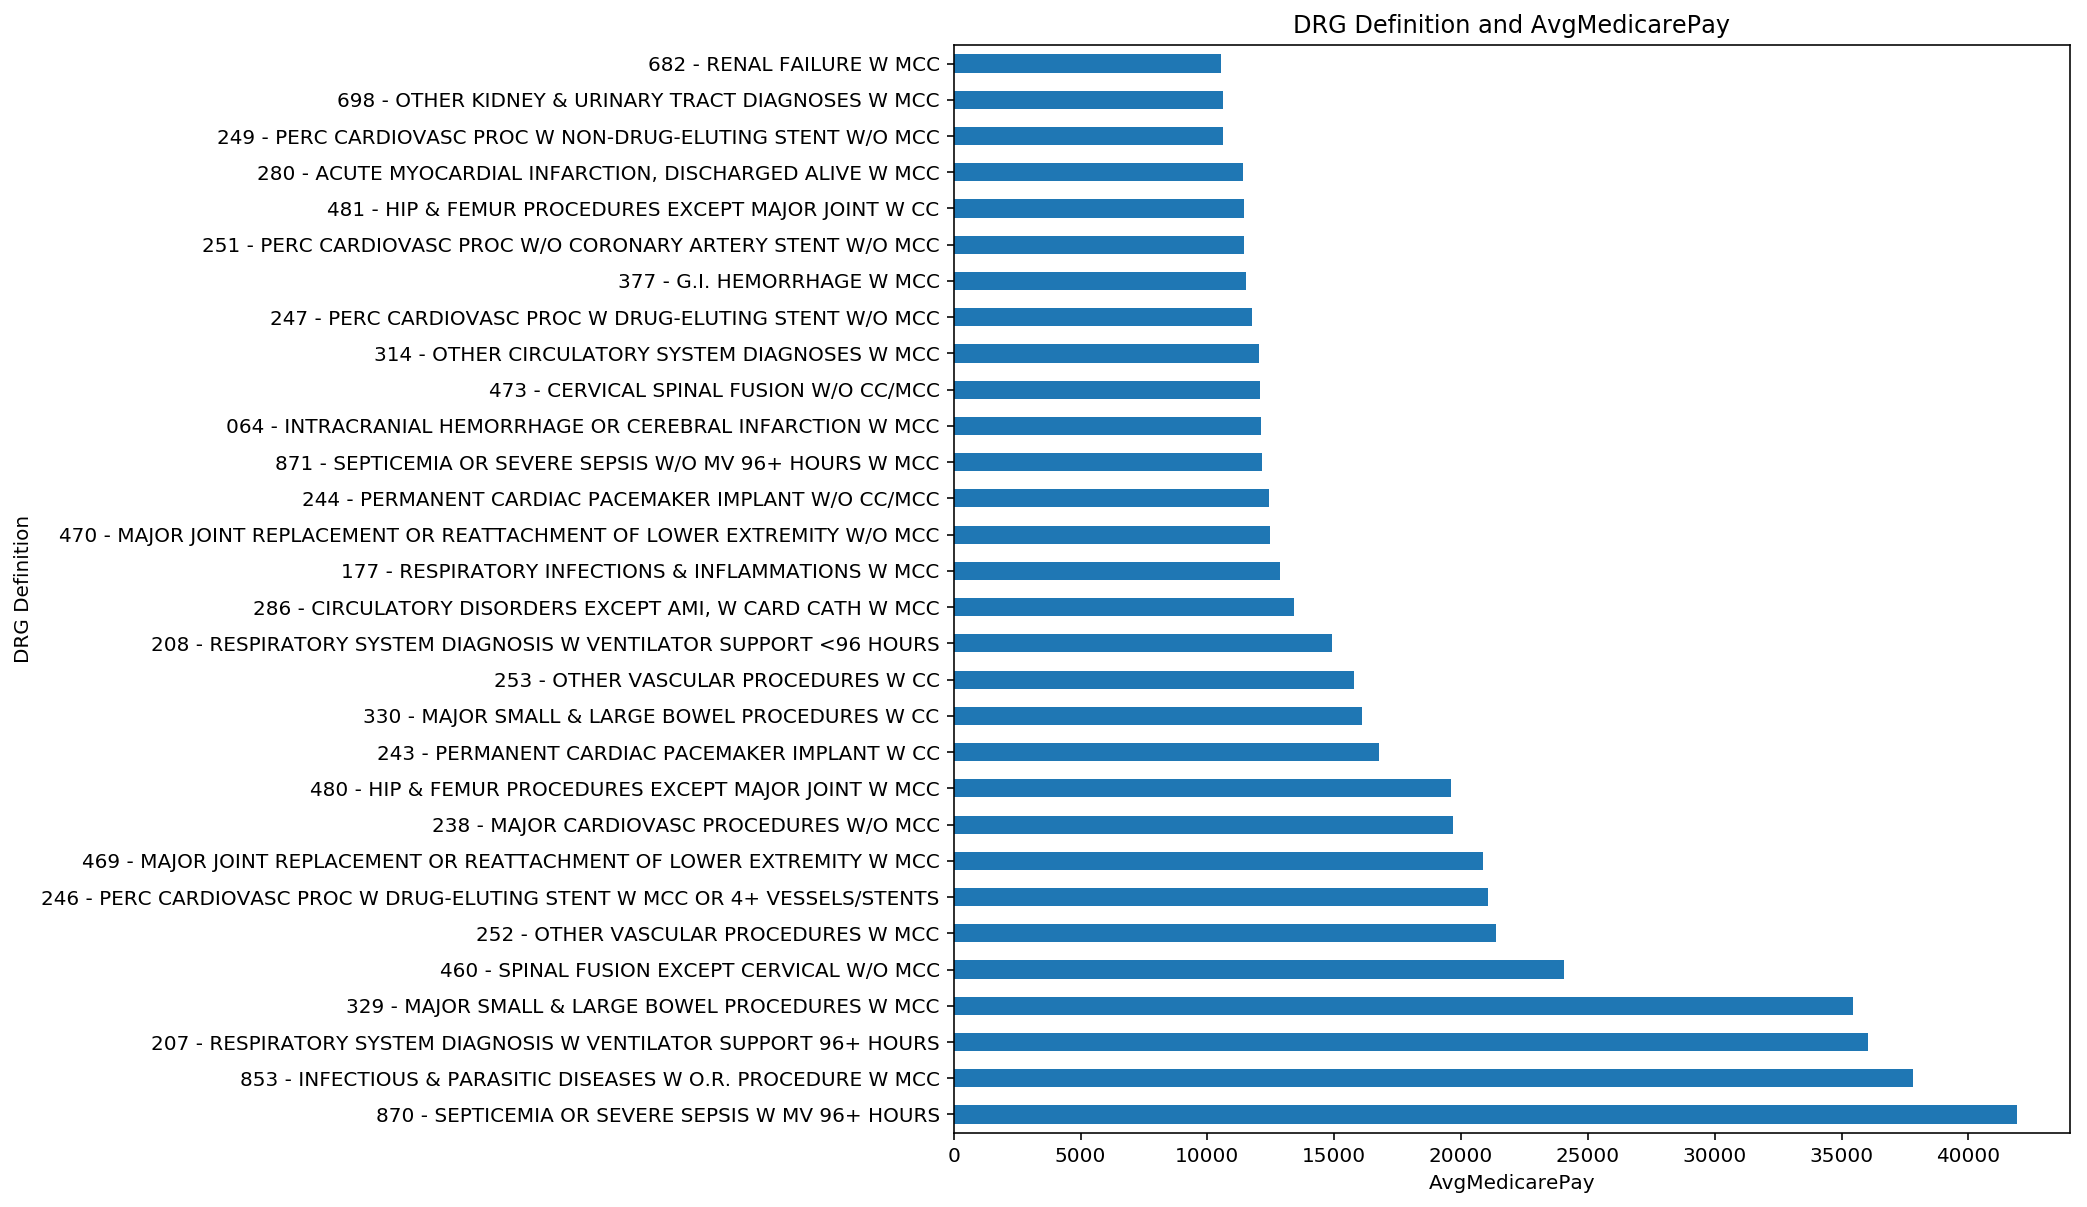

In [159]:
# Graph showing Avg Medicare payment per DRG Definition
fig, ax = plt.subplots(figsize = (10, 10))
st2.groupby('DRG Definition')['AvgMedicarePay'].mean().sort_values(ascending=False).head(30).plot('barH', 
                                                                     ax = ax, title = 'DRG Definition and AvgMedicarePay')
plt.xlabel('AvgMedicarePay')
plt.ylabel('DRG Definition')

#### Write out data set to csv file

In [160]:
# Write to csv file
st2.to_csv('st2.csv', index=False)

## Medicare Hospital Spending by Claim

In [11]:
A_new2 = pd.read_csv('../datasets/Medicare Hospital Spending by Claim.csv', sep = ',')

## Here period and claim_type are my focus to understand the variation in spending among providers, since average spend per episod by hospitals differs among all providers. Hence i would start by understanding the type of care given to a medicare beneficiary as relative to it's claim type and period

#### FUNCTION THAT CLEANS AND RENAME SOME DATAFRAME  COLUMNS AND APPLY MY TRANSFORMATION THEN RETURNS A CLEAN DATAFRAME.

In [163]:
def cleaning(df, column6, column7, column8, column9, column10, column11):
    

    # rename columns
    df=df.rename(columns={'Avg_Spending_Per_Episode_Hospital':'AvgSpendPerEpHosp',
                          'Avg_Spending_Per_Episode_State':'AvgSpendPerEpState',
                         'Avg_Spending_Per_Episode_Nation':'AvgSpendPerEpNat',
                         'Percent_of_Spending_Hospital':'%SpendHosp',
                         'Percent_of_Spending_State':'%SpendState',
                         'Percent_of_Spending_Nation':'%SpendNat'})
    
    # strip string from columns that contain string and convert dtype to float
    df[column6] = [i.replace('$', "") for i in df[column6]]
    df[column6] = df[column6].astype(float)
    df[column7] = [i.replace('$', "") for i in df[column7]]
    df[column7] = df[column7].astype(float)
    df[column8] = [i.replace('$', "") for i in df[column8]]
    df[column8] = df[column8].astype(float)
    df[column9] = [i.replace('%', "") for i in df[column9]]
    df[column10] = [i.replace('%', "") for i in df[column10]]
    df[column11] = [i.replace('%', "") for i in df[column11]]
    
    
    
    
    
    
    return df

### Calling the cleaning function to delimt strings and rename some columns

In [164]:
st3 = cleaning(A_new2,'AvgSpendPerEpHosp','AvgSpendPerEpState','AvgSpendPerEpNat','%SpendHosp','%SpendState','%SpendNat')
    

### Graph showing average spending per episode relative to period by hospitals

Text(0,0.5,'Period')

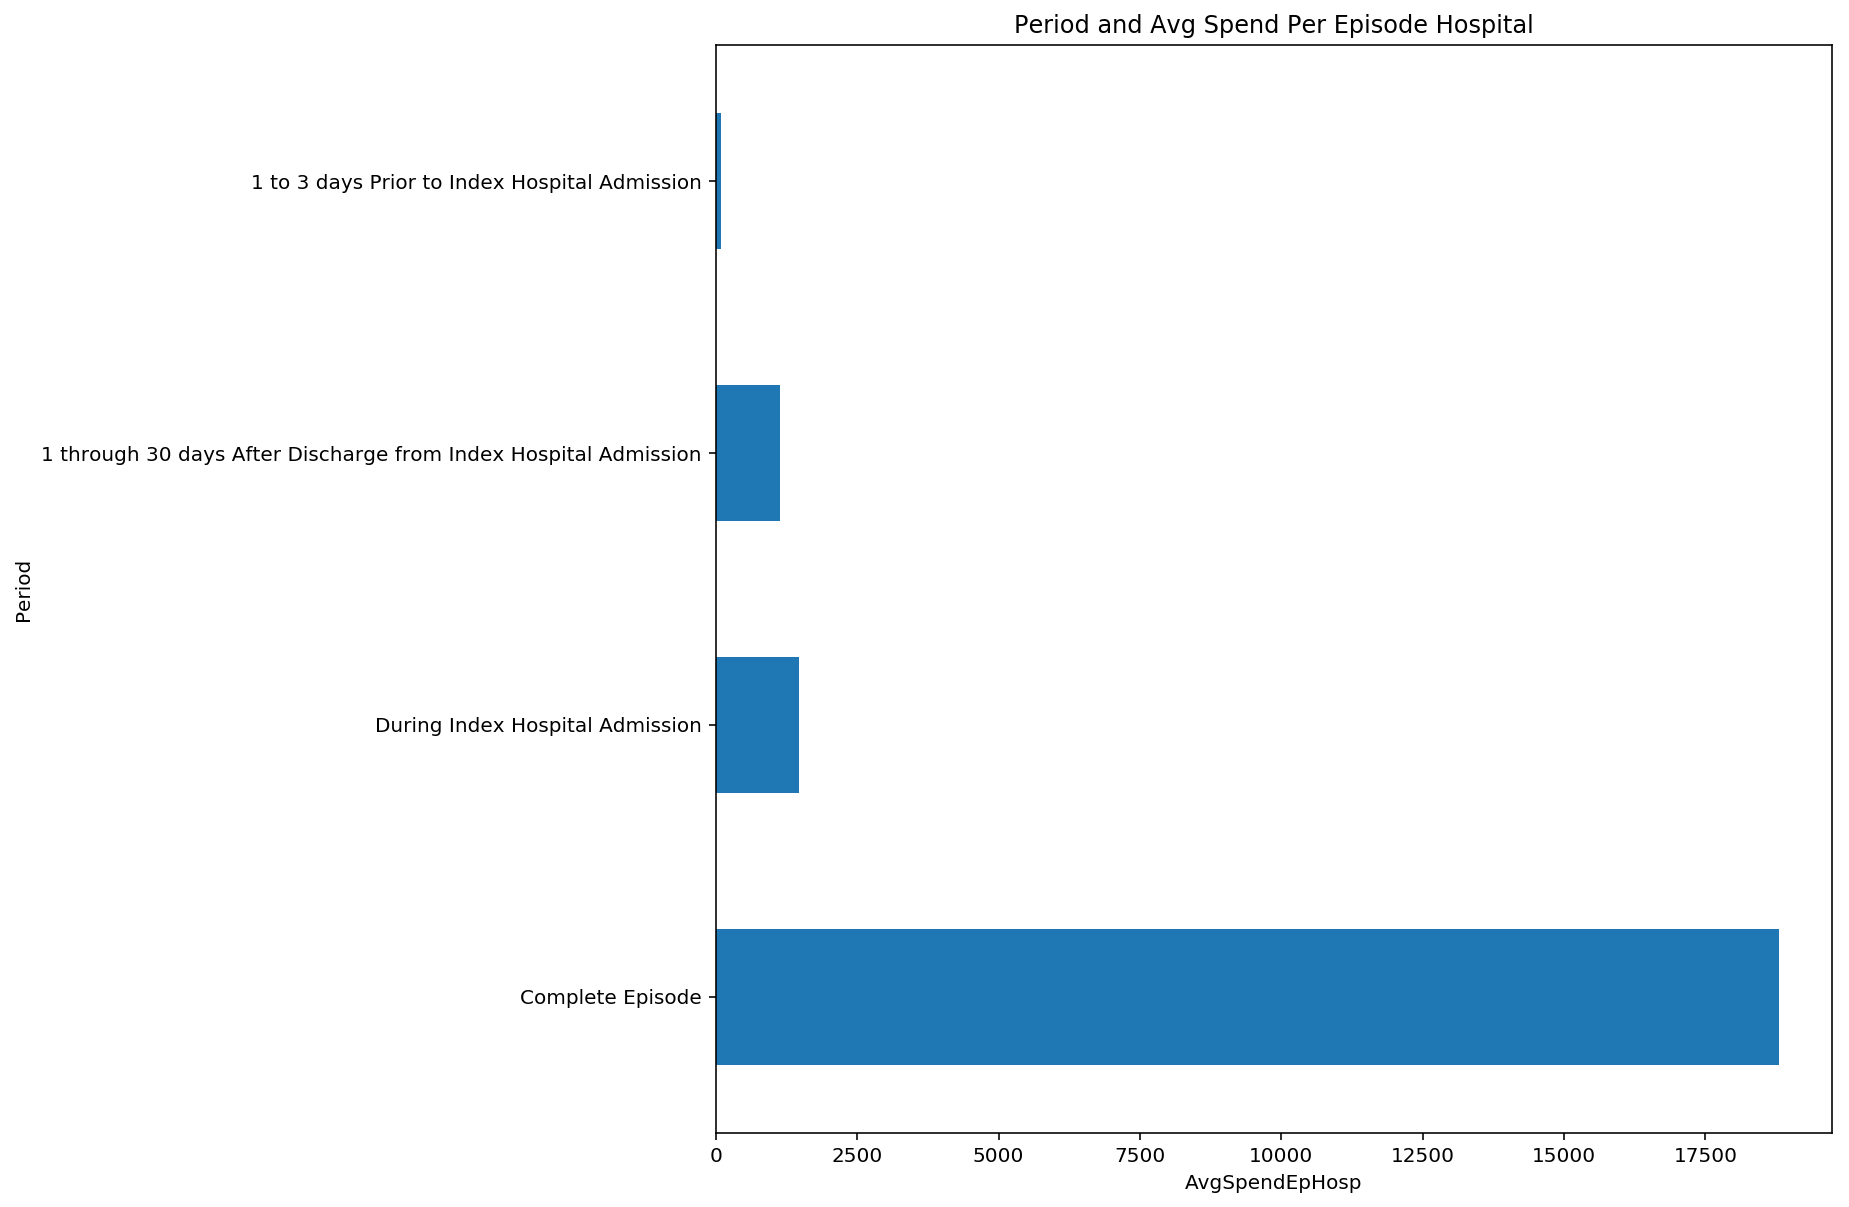

In [166]:
fig, ax = plt.subplots(figsize = (10, 10))
st3.groupby('Period')['AvgSpendPerEpHosp'].mean().sort_values(ascending=False).plot('barH', 
                                                                     ax = ax, title ='Period and Avg Spend Per Episode Hospital')
plt.xlabel('AvgSpendEpHosp')
plt.ylabel('Period')

### Just to visually confirm the graph's result and it seem to be true, Now we have to find those activaities synanimous to periods and claim types which determines the variation in spending averages. Meaning what level of spending on average per episode and the Period for every beneficiary determines claim type

In [167]:
# top 5 period type, claim type and their average spending per episode in each hospital
st3.sort_values(by = 'AvgSpendPerEpHosp',ascending=False).head(3)

,Hospital_Name,Provider_ID,State,Period,Claim_Type,AvgSpendPerEpHosp,AvgSpendPerEpState,AvgSpendPerEpNat,%SpendHosp,%SpendState,%SpendNat,Start_Date,End_Date
13290,MIRACLE MILE MEDICAL CENTER,50751,CA,Complete Episode,Total,49490.0,20846.0,20302.0,100,100,100,1012016,12312016
43858,MIRACLE MILE MEDICAL CENTER,50751,CA,During Index Hospital Admission,Inpatient,40362.0,9959.0,9676.0,81.56,47.78,47.66,1012016,12312016
27835,BLUE VALLEY HOSPITAL INC,170201,KS,Complete Episode,Total,35990.0,20103.0,20302.0,100,100,100,1012016,12312016


### Graph showing Claim types and their respective hospital average spending per episode

Text(0,0.5,'Claim_Type')

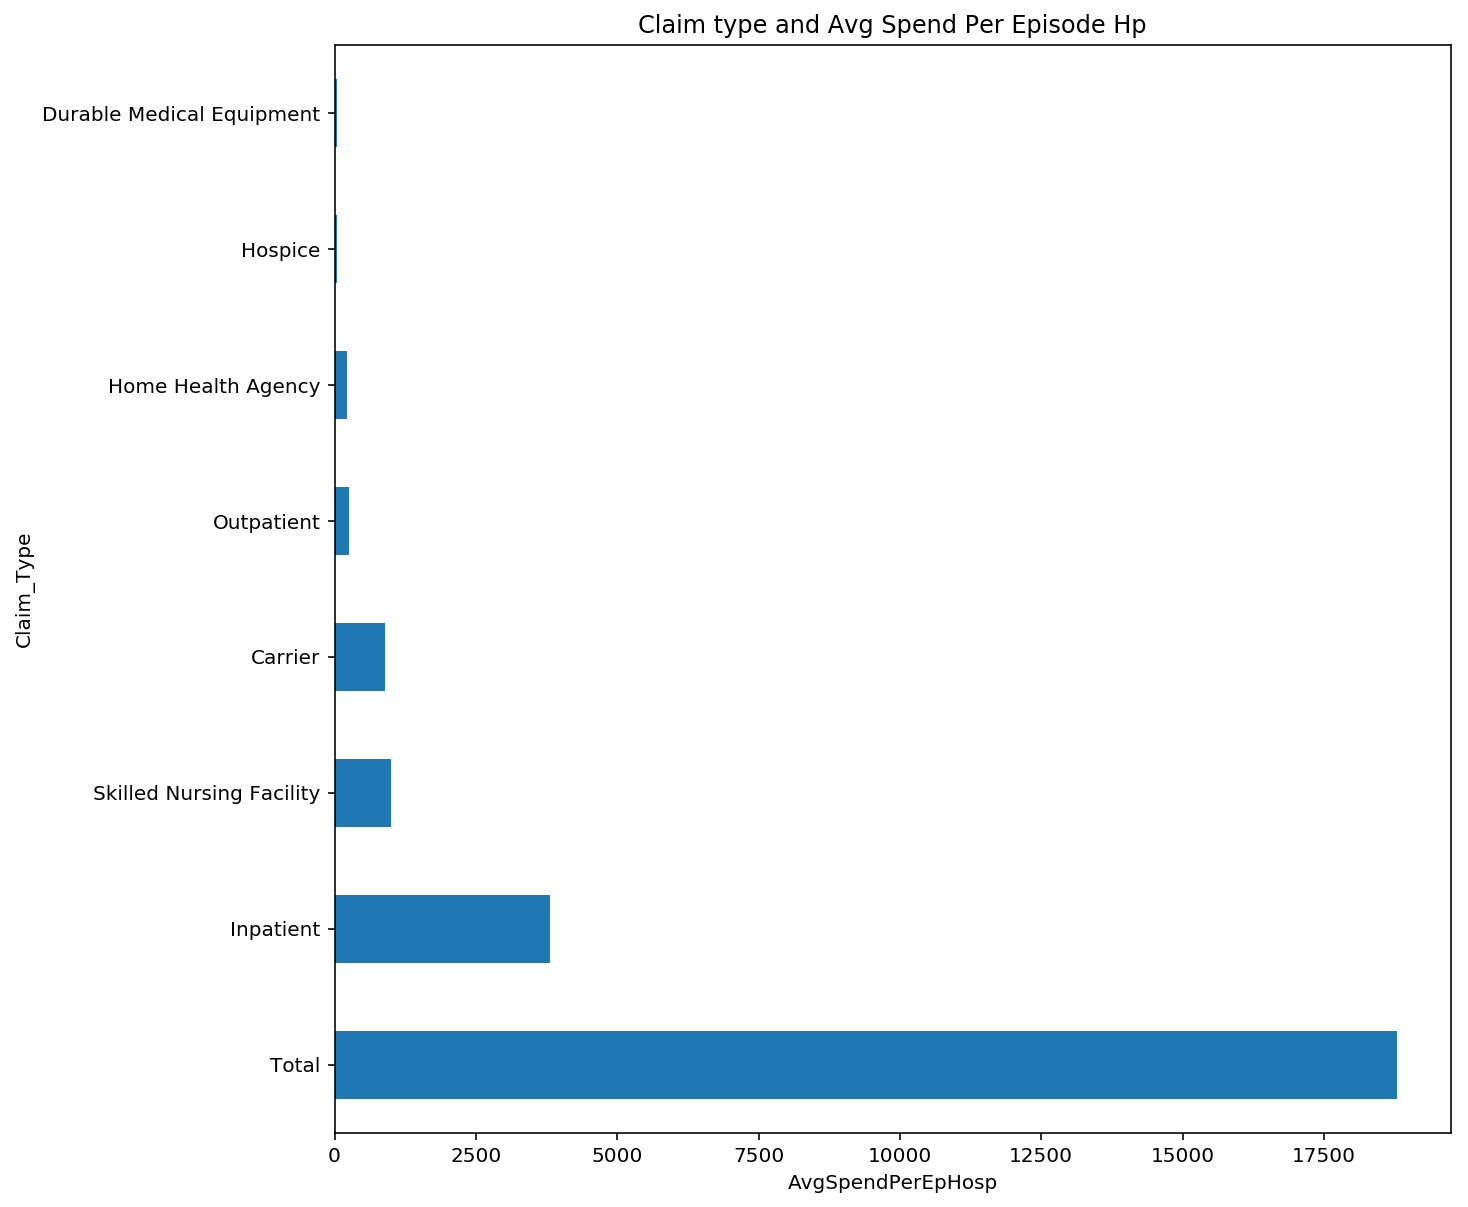

In [168]:
fig, ax = plt.subplots(figsize = (10, 10))
st3.groupby('Claim_Type')['AvgSpendPerEpHosp'].mean().sort_values(ascending=False).plot('barH', 
                                                                     ax = ax, title = 'Claim type and Avg Spend Per Episode Hp')
plt.xlabel('AvgSpendPerEpHosp')
plt.ylabel('Claim_Type')

### This graph shows providers with most spending avrage per episode

We will look further to understand why these providers spend more per episode what makes them different from other providers

Text(0,0.5,'Provider_ID')

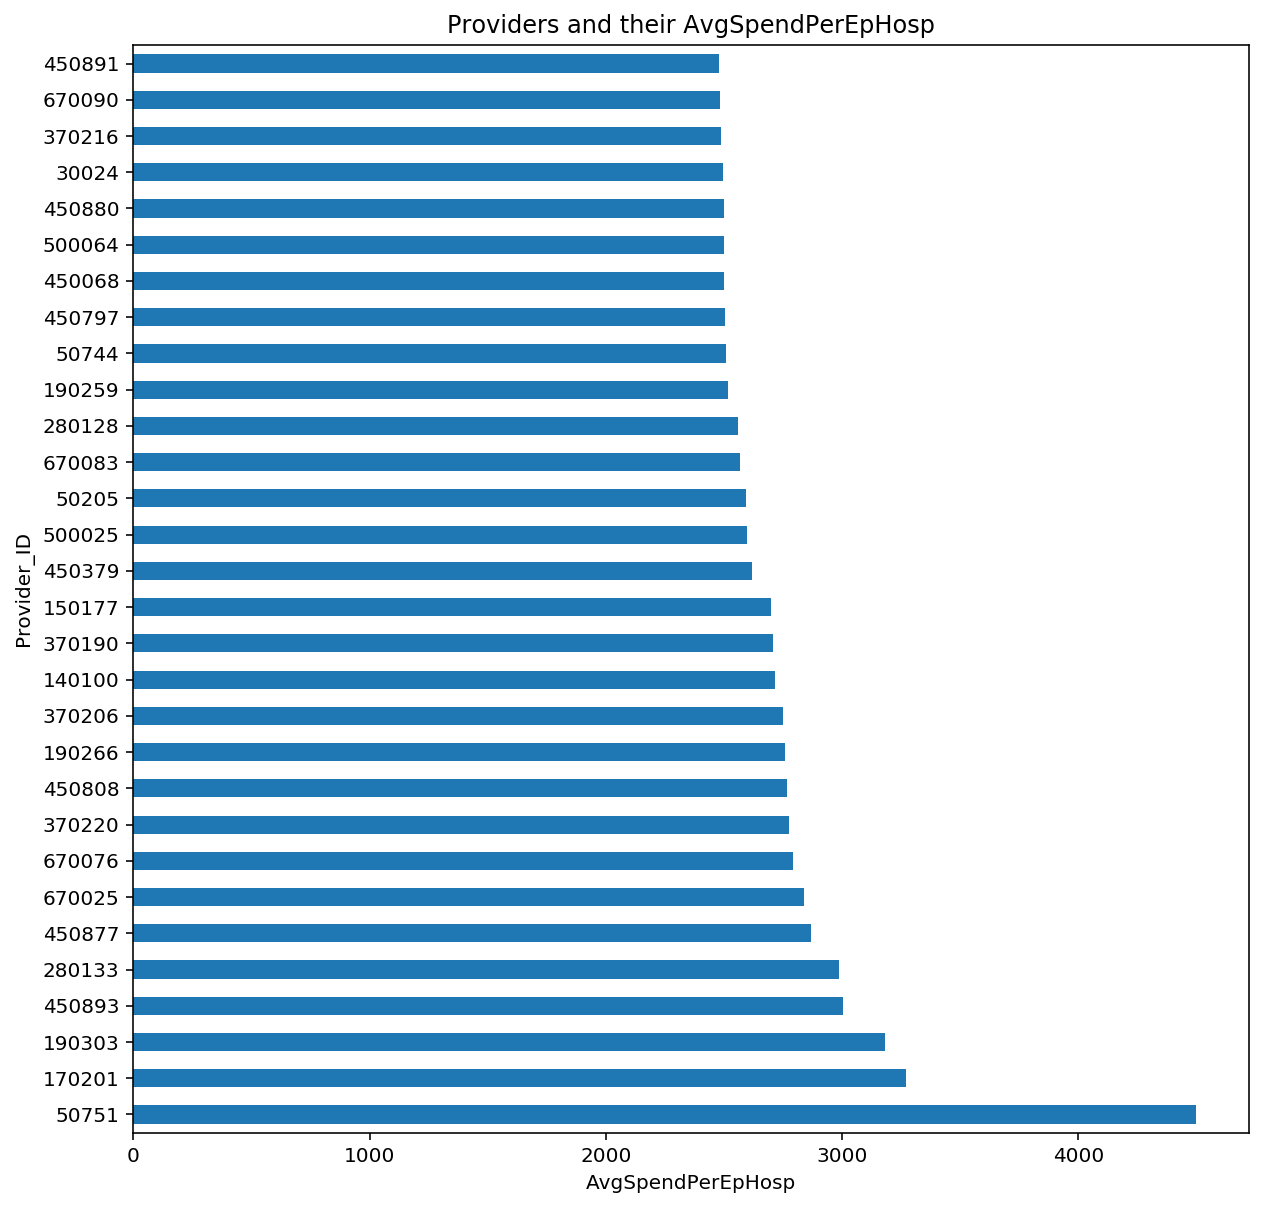

In [169]:
fig, ax = plt.subplots(figsize = (10, 10))
st3.groupby('Provider_ID')['AvgSpendPerEpHosp'].mean().sort_values(ascending=False).head(30).plot('barH', 
                                                                     ax = ax, title = 'Providers and their AvgSpendPerEpHosp')
plt.xlabel('AvgSpendPerEpHosp')
plt.ylabel('Provider_ID')

#### Providers with their respective Average spend per episode. Just to visually confirm the graph result

In [170]:
st3.groupby('Provider_ID')['AvgSpendPerEpHosp'].mean().reset_index().sort_values(by='AvgSpendPerEpHosp', ascending=False).head()

,Provider_ID,AvgSpendPerEpHosp
463,50751,4499.090909
1157,170201,3271.772727
1302,190303,3181.500000
2843,450893,3003.409091
1684,280133,2985.545455


#### Just to visually confirm the graph outcome for different periods and how much hospitals spend per episode 

In [171]:
st3.groupby(['Period'])['AvgSpendPerEpHosp'].mean().reset_index().sort_values(by='AvgSpendPerEpHosp',ascending=False)

,Period,AvgSpendPerEpHosp
2,Complete Episode,18797.474302
3,During Index Hospital Admission,1465.178209
0,1 through 30 days After Discharge from Index H...,1133.327547
1,1 to 3 days Prior to Index Hospital Admission,86.845767


#### Just to visually confirm the graph outcome  for claim types

In [172]:
st3.groupby(['Claim_Type'])['AvgSpendPerEpHosp'].mean().reset_index().sort_values(by='AvgSpendPerEpHosp',ascending=False)

,Claim_Type,AvgSpendPerEpHosp
7,Total,18797.474302
4,Inpatient,3816.027496
6,Skilled Nursing Facility,997.692259
0,Carrier,899.334074
5,Outpatient,249.989742
2,Home Health Agency,225.357974
3,Hospice,42.198287
1,Durable Medical Equipment,35.220389


#### Write out data set to csv file

In [173]:
# Write to csv file
st3.to_csv('st3.csv', index=False)

## A list of hospitals and the availability of structural measures at that hospital. 
A structural measure reflects the environment in which hospitals care for patients. For example, whether or not a hospital participates in a Cardiac Surgery Registry.

In [18]:
# read in csv file
A_new3 = pd.read_csv('../datasets/Structural-Measures-Hospital.csv',engine='python', sep = ',')

In [19]:
A_new3.shape

(33787, 14)

In [176]:
rename2_map = {
    # Original column: [renamed column]
    'Provider ID':    'Provider_ID', 
      }
A_new3.rename(columns=rename2_map, inplace=True)


In [178]:
# dropping columns with Not Available
A_new37 = A_new3[A_new3['Measure Response'] != 'Not Available']

In [180]:
A_new37.head(1)

,Provider_ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Measure Response,Footnote,Measure Start Date,Measure End Date,Location
0,330163,EASTERN NIAGARA HOSPITAL,521 EAST AVENUE,LOCKPORT,NY,14094,NIAGARA,7165145700,Able to receive lab results electronically,OP_12,Yes,NaN,01/01/2016,12/31/2016,"521 EAST AVENUE\nLOCKPORT, NY\n(43.17638, -78...."


In [182]:
# assigning the dateframe to a new dataframe varible
A_new10 = A_new37 

In [183]:
# dropping insignificant variables
A_neww3 = A_new10.drop(['Address','ZIP Code','County Name','Phone Number','Measure ID','Footnote',
                      'Measure Start Date','Measure End Date','Location'], axis = 1)

In [185]:
A_neww3.head(2)

,Provider_ID,Hospital Name,City,State,Measure Name,Measure Response
0,330163,EASTERN NIAGARA HOSPITAL,LOCKPORT,NY,Able to receive lab results electronically,Yes
1,330140,ST JOSEPH'S HOSPITAL HEALTH CENTER,SYRACUSE,NY,Safe surgery checklist use (outpatient),Yes


In [186]:
A_neww3.shape

(25080, 6)

In [187]:
# Write to csv file
A_neww3.to_csv('A_neww3.csv', index=False)

## Medicare hospital spending per patient . 
The "Medicare hospital spending per patient (Medicare Spending per Beneficiary)" measure shows whether Medicare spends more, less or about the same per Medicare patient treated in a specific hospital, compared to how much Medicare spends per patient nationally. This measure includes any Medicare Part A and Part B payments made for services provided to a patient during the 3 days prior to the hospital stay, during the stay, and during the 30 days after discharge from the hospital.

In [21]:
# Reading in a new csv file
A_new6 = pd.read_csv('../datasets/Medicare Hospital Spending per Patient - Hospital.csv', sep = ',')

In [22]:
A_new6.shape  # The dimension of the new dataframe

(4806, 14)

In [23]:
A_new6.head(2)  # previewing the head

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Score,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Medicare hospital spending per patient (Medica...,MSPB_1,0.99,NaN,01/01/2016,12/31/2016
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Medicare hospital spending per patient (Medica...,MSPB_1,1,NaN,01/01/2016,12/31/2016


In [105]:
#best = A_new6.groupby('Provider ID').first().reset_index()

In [31]:
A_new6.columns  # Had to rename the column of this dataframe so as to be able to join with another dataframe with similiar 
# Provider_ID

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Measure Name', 'Measure ID', 'Score',
       'Footnote', 'Measure Start Date', 'Measure End Date', 'Location'],
      dtype='object')

In [200]:
rename_map = {
    # Original column: [renamed column]
    'Provider ID':    'Provider_ID', 
    'Hospital Name':  'Hospital Name', 
    'Address':  'Address', 
    'City':      'City', 
    'State':        'State', 
    'ZIP Code':         'ZIP', 
    'County Name':     'County', 
    'Phone Number':           'Phone'
      }
A_new6.rename(columns=rename_map, inplace=True)


In [201]:
A_new6.head(1)

,Provider_ID,Hospital Name,Address,City,State,ZIP,County,Phone,Measure Name,Measure ID,Score,Footnote,Measure Start Date,Measure End Date,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Medicare hospital spending per patient (Medica...,MSPB_1,1,NaN,01/01/2016,12/31/2016,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL\n"


In [202]:
# dropping columns don't seem significant
df_Anew = A_new6.drop(['Address','ZIP','County','Phone','Measure ID','Score','Footnote',
                       'Measure Name','Location'],axis=1)

In [203]:
df_Anew.head(2)

,Provider_ID,Hospital Name,City,State,Measure Start Date,Measure End Date
0,10005,MARSHALL MEDICAL CENTER SOUTH,BOAZ,AL,01/01/2016,12/31/2016
1,10012,DEKALB REGIONAL MEDICAL CENTER,FORT PAYNE,AL,01/01/2016,12/31/2016


In [24]:
# Reading in a  ew data set to compliment the ealier data set
A_new6a = pd.read_csv('../datasets/Medicare_hospital_spending_per_patient__Medicare_Spending_per_Beneficiary____Additional_Decimal_Places.csv', sep = ',')

In [25]:
A_new6a.head()  # continuation of A_new6 but with a better Value instead of Score

,Provider_ID,Measure_ID,Value,Footnote,Start_Date,End_Date
0,30085,MSPB-1,.991915,NaN,1012016,12312016
1,30092,MSPB-1,1.003283,NaN,1012016,12312016
2,30094,MSPB-1,1.019643,NaN,1012016,12312016
3,30101,MSPB-1,.904839,NaN,1012016,12312016
4,30117,MSPB-1,.877449,NaN,1012016,12312016


In [206]:
# droping insignificant varibles
df_Anew1 = A_new6a.drop(['Measure_ID','Footnote','Start_Date','End_Date'], axis=1)

In [207]:
df_Anew1.head()

,Provider_ID,Value
0,30085,.991915
1,30092,1.003283
2,30094,1.019643
3,30101,.904839
4,30117,.877449


In [208]:
#[A_new6 and A_new6a dataframe] Joined DataFrames on 
#Provider ID and this serves as my new DataFrame
# The new data set for 3
A_train3 = df_Anew.merge(df_Anew1, on='Provider_ID').groupby(['Provider_ID']).first().reset_index()

In [209]:
A_train3.shape

(3203, 7)

In [210]:
A_train3 = A_train3[['Provider_ID','Hospital Name','City','State','Value',
                     'Measure Start Date','Measure End Date']]

In [211]:
# New merged DataFrame
A_train3.head(2)

,Provider_ID,Hospital Name,City,State,Value,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,AL,.993364,01/01/2016,12/31/2016
1,10005,MARSHALL MEDICAL CENTER SOUTH,BOAZ,AL,.998265,01/01/2016,12/31/2016


In [212]:
# droping the column where valuye is not available 
A_train3 =  A_train3[A_train3['Value'] != 'Not Available']

In [213]:
# asigning a new dtype
A_train3['Value'] = A_train3['Value'].astype(float)


In [214]:
A_train3.shape

(3151, 7)

In [215]:
be = pd.DataFrame(A_train3.groupby(['State']).agg({'Value':'mean'})).reset_index()

In [216]:
be = A_train3.groupby('State').first().reset_index()

In [233]:
be.head(2)

,State,Provider_ID,Hospital Name,City,Value,Measure Start Date,Measure End Date
0,AK,20001,PROVIDENCE ALASKA MEDICAL CENTER,ANCHORAGE,0.908782,01/01/2016,12/31/2016
1,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,DOTHAN,0.993364,01/01/2016,12/31/2016


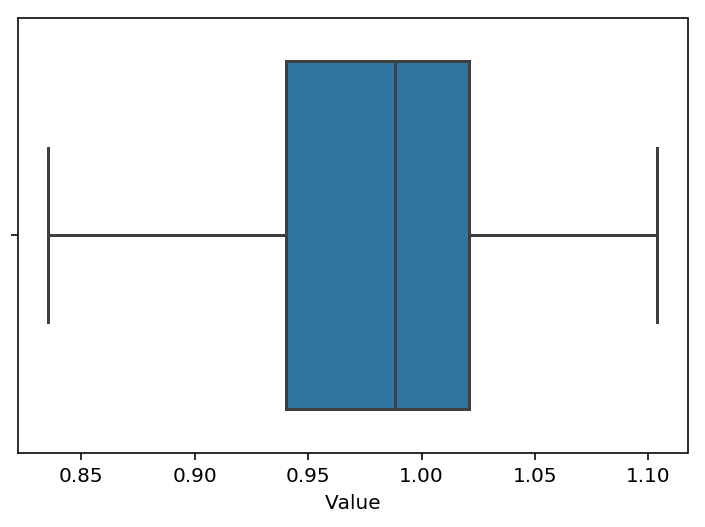

In [218]:
sns.boxplot(be['Value'])

Text(0.5,0,'Values')

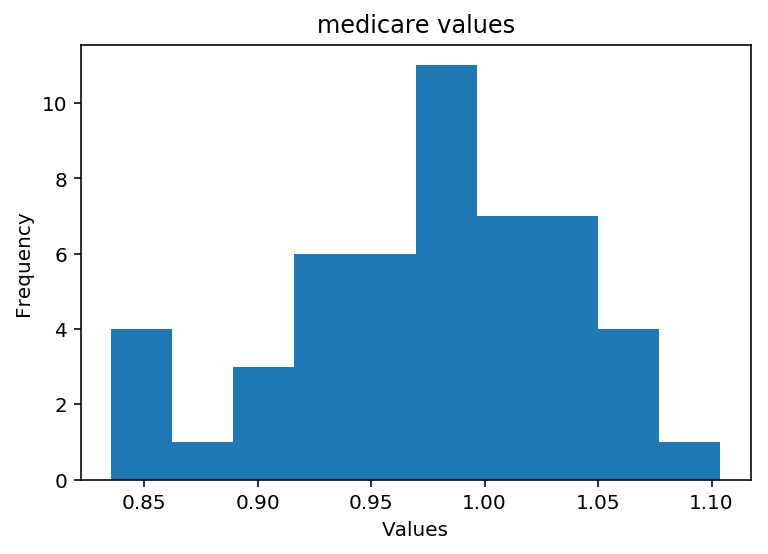

In [219]:
# Histogramm plot showing total sales and date in 2016
be.groupby(['State'])['Value'].first().sort_values(ascending=False).plot('hist', title = 'medicare values')
plt.xlabel('Values')

In [220]:
# Write to csv file
A_train3.to_csv('A_train3.csv', index=False)

In [224]:
# reading in a dataset
df4 = pd.read_csv('A_neww4.csv', engine='python')

In [230]:
df4.head(2)

,Provider_ID,Condition,Measure Name,Score,Sample
0,220065,Emergency Department,Head CT results,60.0,20.0
1,220030,Emergency Department,Head CT results,84.0,19.0


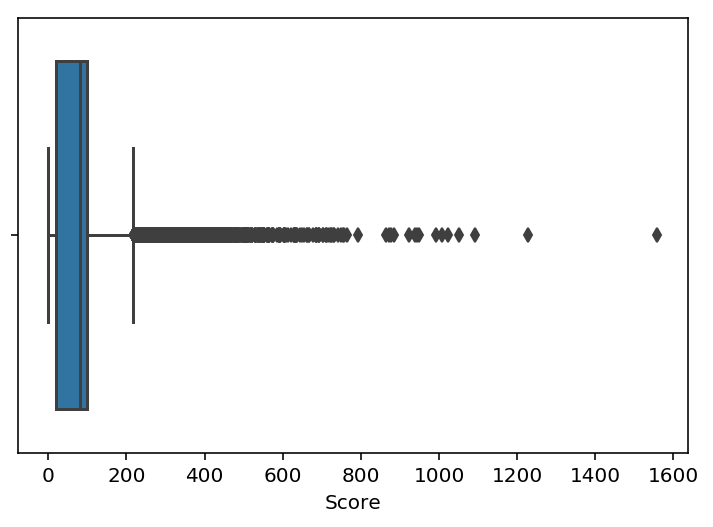

In [231]:
sns.boxplot(df4['Score'])